# <h1 align="center">COSC2753 - Machine Learning</h1>

<h2 align="center">Task 1: Disease Classification</h2>

# TABLE OF CONTENT

[I. IMPORT NECESSARY LIBRARIES](#i-import-necessary-libraries)

[II. MODEL TRAINING: DISEASE CLASSIFICATION](#ii-model-training-disease-classification)

  - [1) Dataset Preprocessing](#1-data-preprocessing)

  - [2) Setup Global Variable](#2-setup-global-variables)

  - [3) Store Image in Generator](#3-store-image-in-generator)
  
  - [4) Baseline Models](#4-baseline-models)

  - [5) Model Selection and Tuning](#5-model-selection-and-tuning)

[III. MODEL PERFORMANCE VISUALIZATION](#iii-model-performance-visualization)

# I. IMPORT NECESSARY LIBRARIES

In [2]:
import os

# Data manipulation libraries
import pandas as pd
import numpy as np
import random
import importlib
import pickle

import numpy as np
from PIL import Image

# Data preprocessing
from sklearn.model_selection import train_test_split

# Sklearn Library
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Import custom libraries
import utils.visualizations as vi
import utils.preprocessing as pr
import utils.model_training as mt

importlib.reload(vi)
importlib.reload(pr)
importlib.reload(mt);

## Import Tensorflow for TensorFlow ≤ 2.12

In [ ]:
# # Deep learning libraries
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization,Activation,
# from tensorflow.keras.optimizers import Adam
# tensorflow.keras.applications import VGG16
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.initializers import GlorotUniform
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.models import load_model, Model

## Using Keras for Keras 3.x with TensorFlow ≥ 2.13

In [3]:
# Deep learning libraries
import tensorflow as tf
from keras import Sequential, layers, models, Input
from keras.regularizers import l2
from keras.layers import (
    Dense,
    Flatten,
    Dropout,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Activation,
    GlobalAveragePooling2D,
)
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.initializers import GlorotUniform
from keras.models import load_model, Model

# II. MODEL TRAINING: DISEASE CLASSIFICATION

To ensure that the results are stable for multiple run time, we setup the seed for dataset

In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 1) Data Preprocessing

In [5]:
df = pd.read_csv("./inputs/training_df.csv")

In [6]:
# Define random_state
random_state = 42

train_df, val_df = train_test_split(df, test_size=0.2, random_state=random_state)

vi.print_header("Train Dataset shape")
print("Number of Rows: ", train_df.shape[0])
print("Number of Columns: ", train_df.shape[1])

vi.print_header("Validation Dataset Shape")
print("Number of Rows: ", val_df.shape[0])
print("Number of Columns: ", val_df.shape[1])

+-----------------------------------------+
|           TRAIN DATASET SHAPE           |
+-----------------------------------------+
Number of Rows:  8325
Number of Columns:  5
+----------------------------------------------+
|           VALIDATION DATASET SHAPE           |
+----------------------------------------------+
Number of Rows:  2082
Number of Columns:  5


## 2) Setup global variables

`OUTPUT_CLASSES = 10`
This defines the number of output classes. Since the dataset contains 10 categories (9 disease types and 1 healthy class), the model must have 10 output units to predict the correct class for each image.

`BATCH_SIZE = 32`
The batch size is set to 32 as a common standard that balances model training efficiency and computational resources. It allows for reasonable updates while managing memory usage.

`INPUT_DIM = (64, 64, 3)`
The input dimension is 64x64 pixels with 3 color channels (RGB). This size is a standard choice, balancing computational cost with sufficient image detail for the task.



In [7]:
OUTPUT_CLASSES = 10
BATCH_SIZE = 32
INPUT_DIM = (128,128,3)

## 3) Store image in generator

The `ImageDataGenerator` is used to rescale pixel values to a [0, 1] range, which is a standard preprocessing step for neural networks. The `data_format='channels_last'` ensures the data is structured with color channels last, as required by many deep learning frameworks.

The `flow_from_dataframe` method is used because the image paths and labels are stored in a DataFrame. It makes it easy to load the images along with their labels directly from the DataFrame, allowing for efficient batch processing during training.

The images are resized to 64x64 pixels to standardize the input size for the model. This resolution is a common trade-off between detail and computational efficiency for image classification tasks.

The `class_mode='categorical'` is used because the task involves multi-class classification. This ensures the labels are one-hot encoded, suitable for a multi-class output.

The fixed `seed=42` is set to ensure reproducibility, making the data shuffling consistent across different runs of the model.

In [ ]:
train_df["label"] = train_df["label"].astype("str")
val_df["label"] = val_df["label"].astype("str")

train_datagen = ImageDataGenerator(rescale=1.0 / 255, data_format="channels_last")
val_datagen = ImageDataGenerator(rescale=1.0 / 255, data_format="channels_last")

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="",
    x_col="image_path",
    y_col="label",
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=SEED,
    shuffle=False,
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory="",
    x_col="image_path",
    y_col="label",
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=SEED,
    shuffle=False,
)

Found 8325 validated image filenames belonging to 10 classes.
Found 2082 validated image filenames belonging to 10 classes.


## 4) Baseline Models

In this baseline models comparison, we set the average epochs for all models to be 25, this is to ensure the fairness between all models and for clearer visualizations. Moreover, we compiled all models with `Adam` optimizer and the loss function of `categorical_crossentropy`. 

- `Adaptive Learning Rates`: It helps to adapt the learning rate for each parameter in the model. This is highly beneficial as different parameters might require different update magnitudes to learn effectively. With combination of `categorical_crossentropy`, we can be more effective when it comes to dealing with complex, high-dimensional loss landscapes. 

When paired with `categorical_crossentropy`, the Adam optimizer effectively leverages its aforementioned advantages to significantly boost the model's performance in multi-class classification tasks.


### 4.1) VGG16

The VGG16 is the deep convolutional neural network (CNN) with 16 layers, with 3x3 convolution filter and uniform architecture. It is widely used image classification tasks due to its strong performance and ease of implementation.

In [7]:
# Load base VGG16 without top
vgg16_base_model = VGG16(
    include_top=False, weights=None, input_shape=INPUT_DIM, pooling="avg"
)

# Add classification head
x = vgg16_base_model.output
output = Dense(OUTPUT_CLASSES, activation="softmax")(x)

# Create final model
vgg16_model = Model(inputs=vgg16_base_model.input, outputs=output)

In [54]:
vgg16_model.summary()

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,982,474 (57.15 MB)

 Trainable params: 14,982,474 (57.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model
vgg16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_path = "./models/vgg16.keras"
history_path = "./models/history/vgg16_history.pkl"

# load the model and it's history if it exists in folder directory
if os.path.exists(model_path) and os.path.exists(history_path):
    print("Loading saved model and training history...")
    vgg16_model = load_model(model_path)

    with open(history_path, "rb") as f:
        vgg16_history = pickle.load(f)
    print("Model and history loaded successfully!")
else:
    vgg16_history = vgg16_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        verbose=1,
    )
    # Save history and model
    mt.save_model_and_history(vgg16_model, vgg16_history, model_name="vgg16")

Epoch 1/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 799s 3s/step - accuracy: 0.1507 - loss: 2.2110 - val_accuracy: 0.1561 - val_loss: 2.1774
Epoch 2/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 736s 3s/step - accuracy: 0.1646 - loss: 2.1716 - val_accuracy: 0.1561 - val_loss: 2.1754
Epoch 3/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 732s 3s/step - accuracy: 0.1662 - loss: 2.1729 - val_accuracy: 0.1561 - val_loss: 2.1730
Epoch 4/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 811s 3s/step - accuracy: 0.1732 - loss: 2.1598 - val_accuracy: 0.1700 - val_loss: 2.1722
Epoch 5/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 793s 3s/step - accuracy: 0.1698 - loss: 2.1617 - val_accuracy: 0.1513 - val_loss: 2.1737
Epoch 6/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 780s 3s/step - accuracy: 0.1592 - loss: 2.1642 - val_accuracy: 0.1561 - val_loss: 2.1715
Epoch 7/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 743s 3s/step - accuracy: 0.1695 - loss: 2.1629 - val_accuracy: 0.1700 - val_loss: 2.1717
Epoch 8/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 693s 3s/step - accuracy: 0.1713 - loss: 2.1658 - val_accu

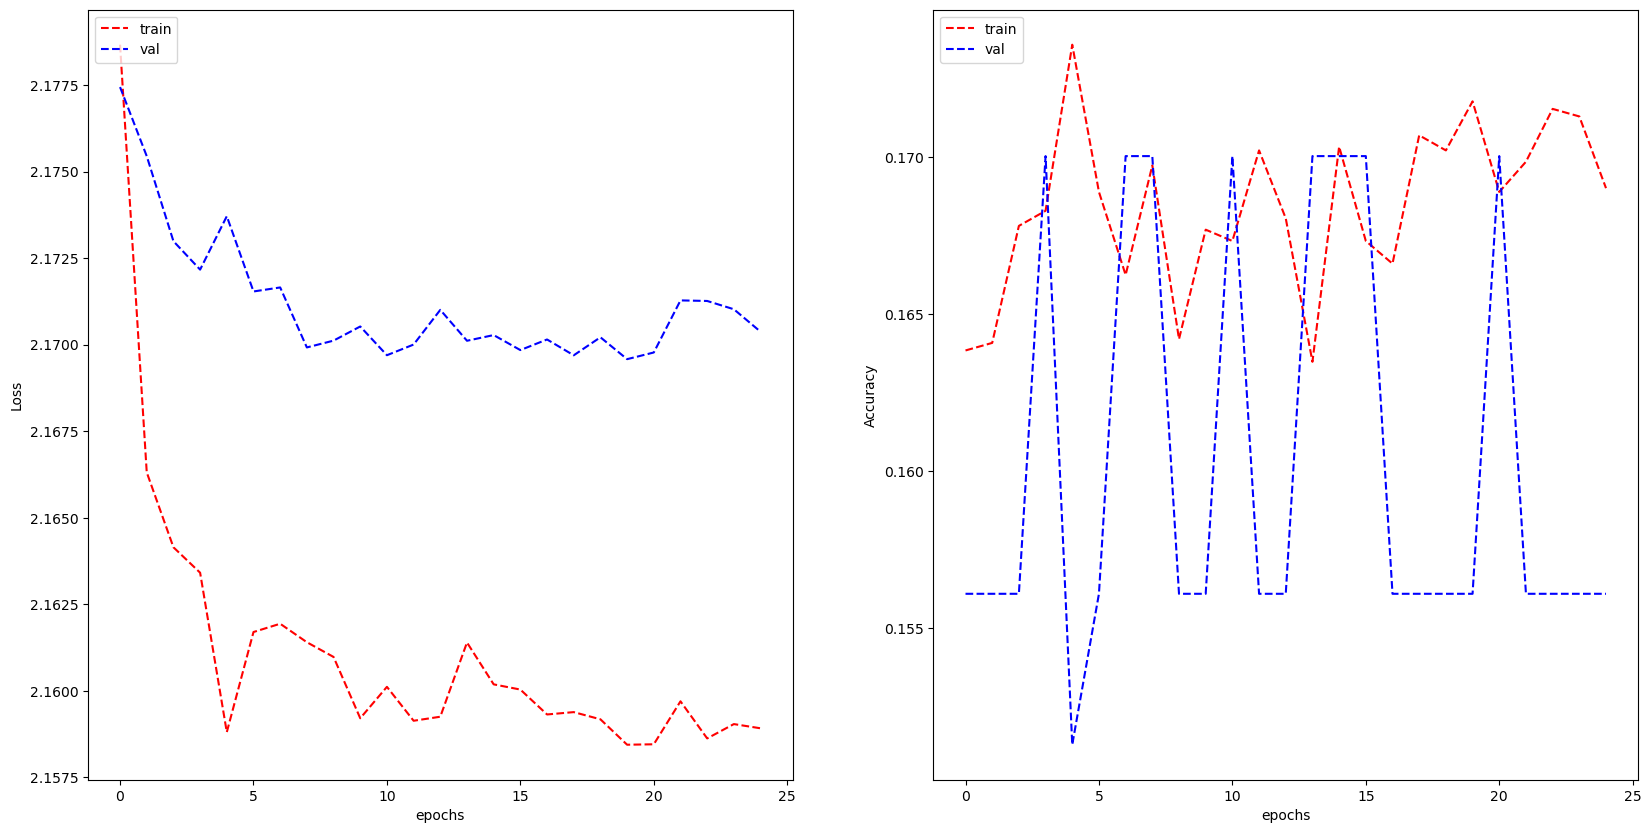

In [84]:
# plot the learning curve
mt.plot_learning_curve(
    vgg16_history.history["loss"],
    vgg16_history.history["val_loss"],
    vgg16_history.history["accuracy"],
    vgg16_history.history["val_accuracy"],
)

Although VGG16 is a robust model, it still performs poorly in our case. This may be due to the model's complexity compared to the small dataset size.

The training dataset only contains around 8,000 images, while the `VGG16` has approximately 138 million parameters, making it very **data-hungry**. Therefore, it suggests that the simpler architectures may be more suitable for this dataset.

### 4.2) Custom Mini VGG

for `Custom Mini VGG`, we designed it consisting of 3 convolutional blocks with increasing filters (kernels) of 16, 32, 64, each followed by max pooling layer. This architecture is based on the design of principles of `VGG16` but significantly simplified to suit the dataset size and reduce training cost.

In [85]:
mini_vgg = Sequential(
    [
        Conv2D(16, (3, 3), activation="relu", input_shape=INPUT_DIM),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(1024, activation="relu"),
        Dense(128, activation="relu"),
        Dense(OUTPUT_CLASSES, activation="softmax"),
    ]
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
mini_vgg.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │    12,846,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,002,154 (49.60 MB)

 Trainable params: 13,002,154 (49.60 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
mini_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [89]:
model_path = "./models/mini_vgg.keras"
history_path = "./models/history/mini_vgg_history.pkl"

# load the model and it's history if it exists in folder directory
if os.path.exists(model_path) and os.path.exists(history_path):
    print("Loading saved model and training history...")
    mini_vgg_model = load_model(model_path)

    with open(history_path, "rb") as f:
        mini_vgg_history = pickle.load(f)
    print("Model and history loaded successfully!")
else:
    mini_vgg_history = mini_vgg.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        verbose=1,
    )
    # Save history and model
    mt.save_model_and_history(mini_vgg, mini_vgg_history, model_name="mini_vgg")

Epoch 1/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 33s 124ms/step - accuracy: 0.2767 - loss: 2.0494 - val_accuracy: 0.5149 - val_loss: 1.4299
Epoch 2/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 33s 125ms/step - accuracy: 0.6069 - loss: 1.2038 - val_accuracy: 0.7190 - val_loss: 0.8837
Epoch 3/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 32s 123ms/step - accuracy: 0.8278 - loss: 0.5381 - val_accuracy: 0.8180 - val_loss: 0.6039
Epoch 4/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - accuracy: 0.9413 - loss: 0.1917 - val_accuracy: 0.8266 - val_loss: 0.6307
Epoch 5/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 35s 132ms/step - accuracy: 0.9797 - loss: 0.0785 - val_accuracy: 0.8497 - val_loss: 0.5542
Epoch 6/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 36s 137ms/step - accuracy: 0.9846 - loss: 0.0539 - val_accuracy: 0.8588 - val_loss: 0.6357
Epoch 7/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 34s 131ms/step - accuracy: 0.9936 - loss: 0.0231 - val_accuracy: 0.8353 - val_loss: 0.7842
Epoch 8/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 35s 132ms/step - accuracy: 0.9833 - loss: 0

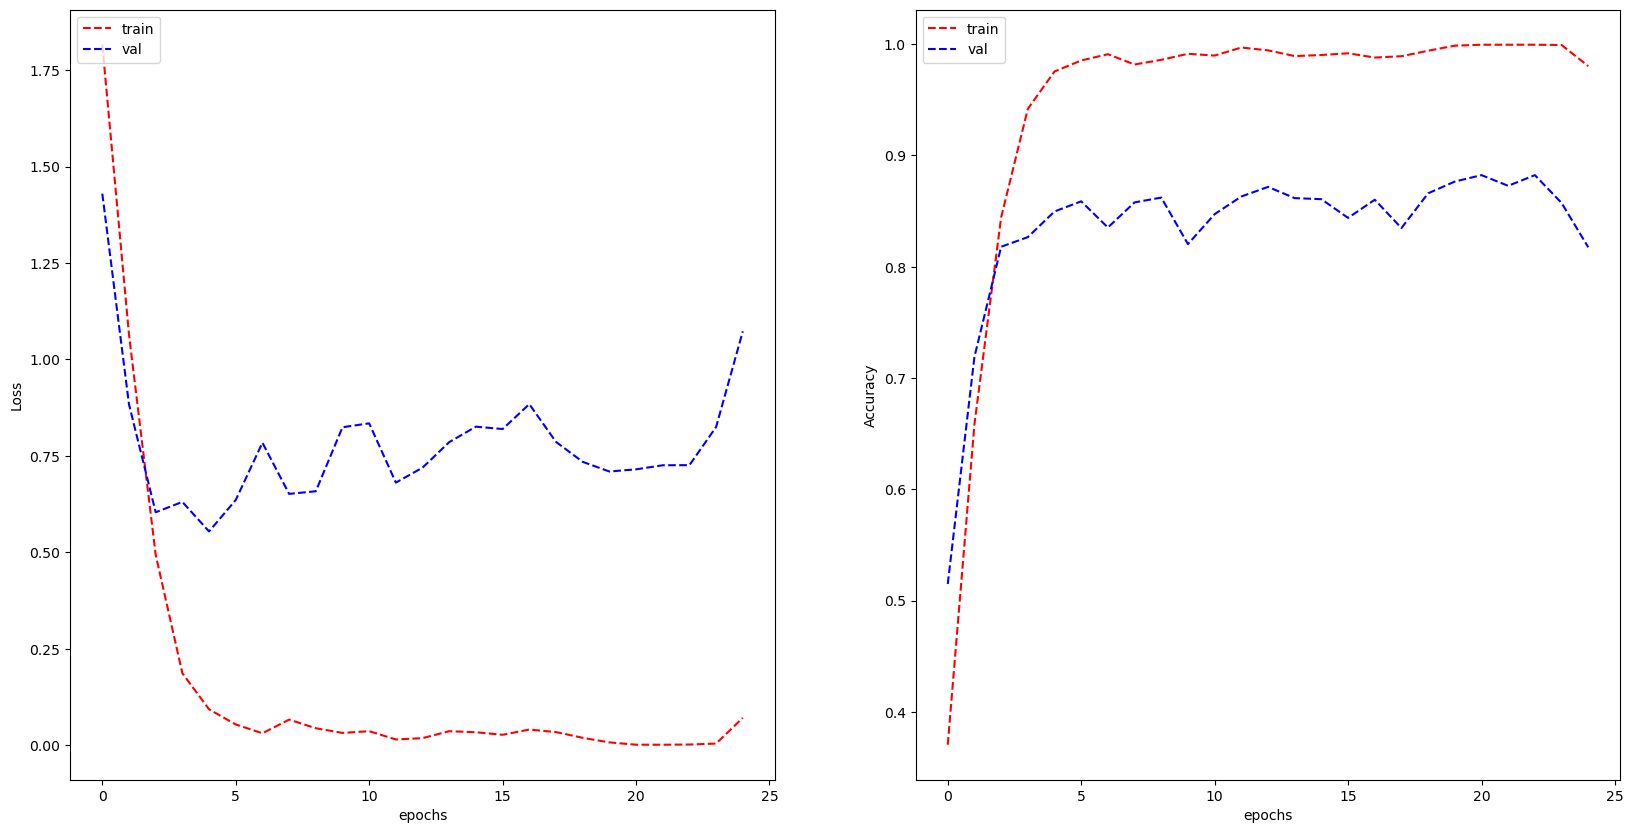

In [92]:
mt.plot_learning_curve(
    mini_vgg_history.history["loss"],
    mini_vgg_history.history["val_loss"],
    mini_vgg_history.history["accuracy"],
    mini_vgg_history.history["val_accuracy"],
    metric_name="Accuracy",
)

### 4.3) KNN and CNN + SVC Model

Trước khi train CNN và SVC Model thì phải qua bước extractor... xong rồi mơi train ở dưới


The model is a combination of a Convolutional Neural Network (CNN) and a K-Nearest Neighbors (KNN) classifier. The CNN is used for feature extraction, while the KNN classifier is used for the final classification.

In [93]:
# Function to extract features using the model
def extract_features(feature_extractor, generator):
    features = []
    labels = []
    for i in range(len(generator)):
        batch_images, batch_labels = generator[i]  # Get batch from generator
        batch_features = feature_extractor.predict(
            batch_images, verbose=0
        )  # Get features from CNN
        features.append(batch_features)
        labels.append(batch_labels)

        # If it's the last batch, break the loop
        if len(features) * generator.batch_size >= generator.samples:
            break

    # Convert to numpy arrays
    features = np.vstack(features)
    labels = np.vstack(labels)

    return features, labels

In [94]:
# Create the GlorotUniform initializer with a seed
initializer = GlorotUniform(seed=SEED)
# Define the feature extraction part
feature_extractor = Sequential(
    [
        Conv2D(
            16,
            (3, 3),
            activation="relu",
            input_shape=INPUT_DIM,
            kernel_initializer=initializer,
        ),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
    ]
)

for layer in feature_extractor.layers:
    if hasattr(layer, "kernel_initializer"):
        layer.kernel.assign(layer.kernel_initializer(layer.kernel.shape))

# Compile the feature extractor
feature_extractor.compile(
    optimizer="adam", loss=None
)  # No loss needed for feature extraction

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [95]:
# Extract features and labels from the train and validation generators
train_features, train_labels = extract_features(feature_extractor, train_generator)
val_features, val_labels = extract_features(feature_extractor, val_generator)

# Flatten the labels to 1D (from one-hot encoding) for KNN
train_labels_flat = np.argmax(train_labels, axis=1)
val_labels_flat = np.argmax(val_labels, axis=1)

#### KNN Model

In [101]:
model_path = "models/knn.pkl"

# Load if the model exists
if os.path.exists(model_path):
    print("Loading saved KNN model...")
    with open(model_path, "rb") as f:
        knn_modelfdassfd = pickle.load(f)
    print("Model loaded successfully!")
else:
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(train_features, train_labels_flat)
    mt.save_sklearn_model(knn_model, "knn")

Loading saved KNN model...
Model loaded successfully!


In [96]:
model_path = "models/knn.pkl"

# Load if the model exists
if os.path.exists(model_path):
    print("Loading saved KNN model...")
    with open(model_path, "rb") as f:
        knn_model = pickle.load(f)
    print("Model loaded successfully!")
else:
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(train_features, train_labels_flat)
    mt.save_sklearn_model(knn_model, "knn")

Model saved to models/knn.joblib


In [104]:
# Make predictions on the validation set
knn_train_pred = knn_model.predict(train_features)
# Make predictions on the validation set
knn_val_pred = knn_model.predict(val_features)

In [105]:
# Evaluate the model accuracy
knn_train_accuracy = accuracy_score(train_labels_flat, knn_train_pred)
print(f"Train accuracy of the CNN + KNN model: {knn_train_accuracy * 100:.2f}%")

# Evaluate the model accuracy
knn_val_accuracy = accuracy_score(val_labels_flat, knn_val_pred)
print(f"Validation accuracy of the CNN + KNN model: {knn_val_accuracy * 100:.2f}%")

Train accuracy of the CNN + KNN model: 84.95%
Validation accuracy of the CNN + KNN model: 74.74%


#### CNN + SVC Models

The model is a combination of a Convolutional Neural Network (CNN) and a Support Vector Classifier (SVC). The CNN is used for feature extraction, while the SVC classifier is used for the final classification.

In [106]:
model_path = "models/svc.pkl"

# Load if the model exists
if os.path.exists(model_path):
    print("Loading saved KNN model...")
    with open(model_path, "rb") as f:
        svc_model = pickle.load(f)
    print("Model loaded successfully!")
else:
    # Train an SVM classifier on the extracted features
    svc_model = SVC(kernel="rbf", C=1.0, gamma="scale")
    svc_model.fit(train_features, train_labels_flat)
    mt.save_sklearn_model(svc_model, "svc")

Model saved to models/svc.pkl


In [107]:
# Make predictions on the test set
svc_val_pred = svc_model.predict(val_features)
svc_train_pred = svc_model.predict(train_features)

In [108]:
# Evaluate the SVM model
svc_train_accuracy = accuracy_score(train_labels_flat, svc_train_pred)
print(f"Train Accuracy of the CNN + SVM model: {svc_train_accuracy * 100:.2f}%")

svc_val_accuracy = accuracy_score(val_labels_flat, svc_val_pred)
print(f"Validation Accuracy of the CNN + SVM model: {svc_val_accuracy * 100:.2f}%")

Train Accuracy of the CNN + SVM model: 61.44%
Validation Accuracy of the CNN + SVM model: 56.29%


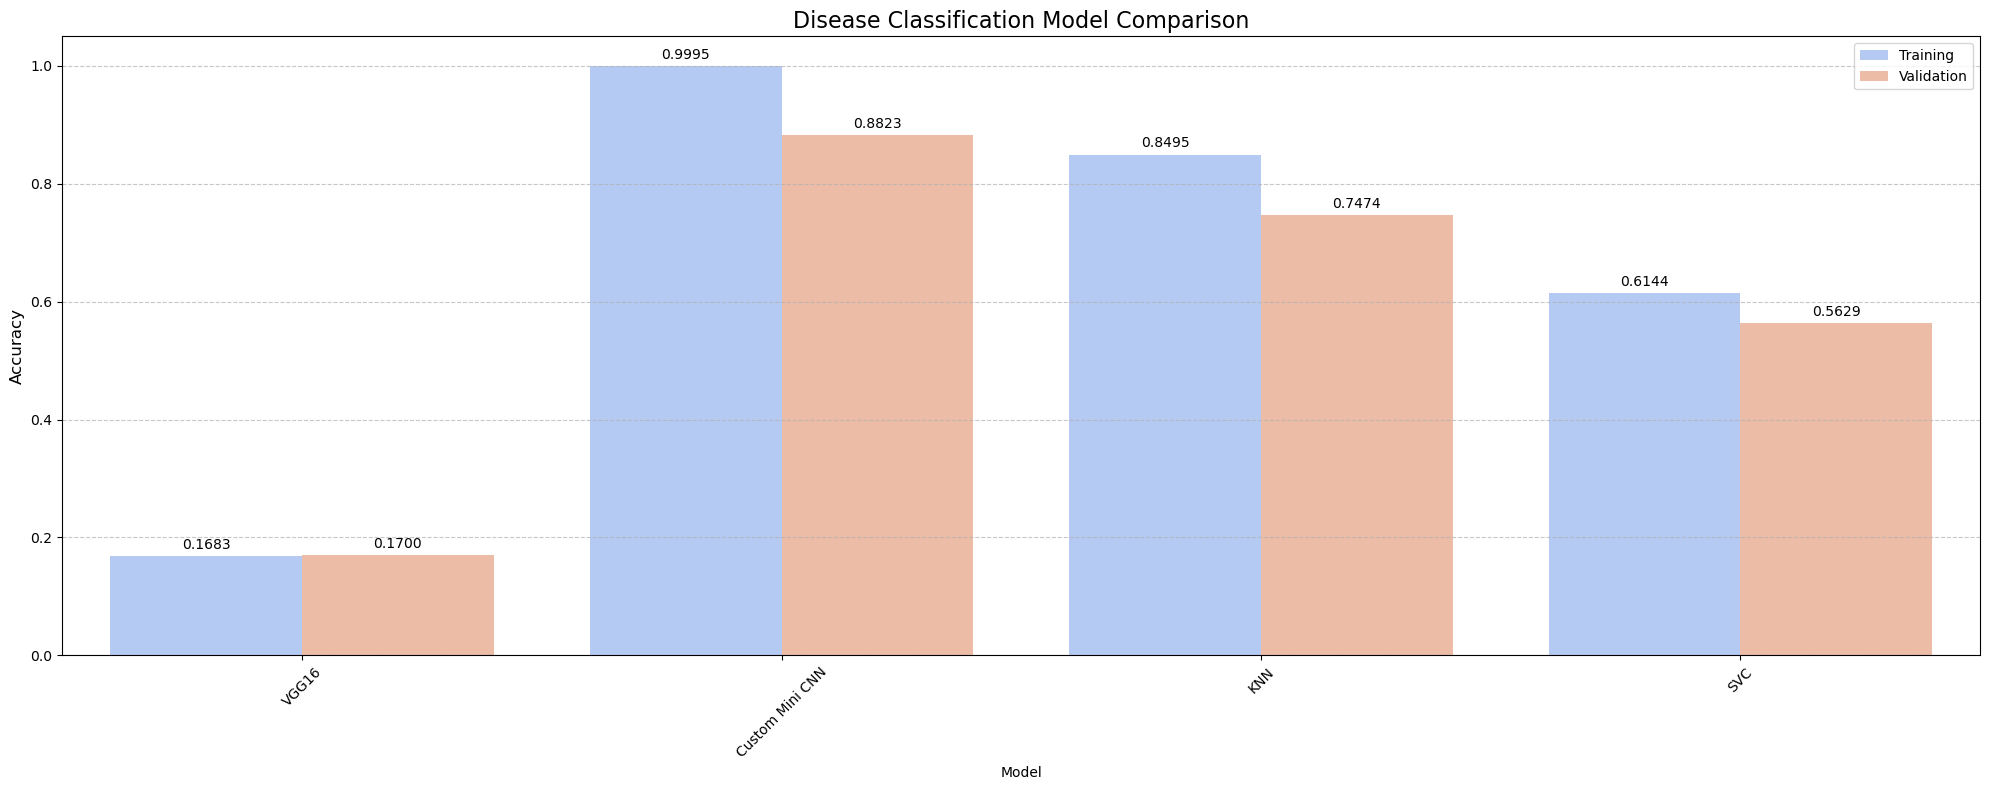

In [111]:
# Get MLP accuracies
best_vgg16_epoch = np.argmax(vgg16_history.history["val_accuracy"])
vgg16_val_accuracy = vgg16_history.history["val_accuracy"][best_vgg16_epoch]
vgg16_train_accuracy = vgg16_history.history["accuracy"][best_vgg16_epoch]

# Get CNN accuracies
best_cnn_epoch = np.argmax(mini_vgg_history.history["val_accuracy"])
cnn_val_accuracy = mini_vgg_history.history["val_accuracy"][best_cnn_epoch]
cnn_train_accuracy = mini_vgg_history.history["accuracy"][best_cnn_epoch]

model_results = {
    "VGG16": (vgg16_train_accuracy, vgg16_val_accuracy),
    "Custom Mini CNN": (cnn_train_accuracy, cnn_val_accuracy),
    "KNN": (knn_train_accuracy, knn_val_accuracy),
    "SVC": (svc_train_accuracy, svc_val_accuracy),
}

mt.plot_model_results(
    model_results, "Disease Classification Model Comparison", figsize=(20, 8)
)

**Oberservation**: The CNN is the best model. Although the CNN is best model with high accuracy on the training set, its accuracy on the validation set is not good as on the training set. For that reason, this model is overfitting. We need to apply some techniques to reduce overfitting.

## 5) Creating Subset

To efficiently perform model selection and hyperparameter tuning, we use the representative, smaller subset of the full dataset. Specifically, we aim to evaluate the performance of several regularization strengths (lambda values) while reducing training time and computational resources.

After determining the best lambda value, we will train the best lambda model again with the whole dataset to find the final result.

In [118]:
subset_df, _ = train_test_split(
    train_df, test_size=0.7, stratify=train_df["label"], random_state=42
)

subset_train_df, subset_val_df = train_test_split(
    subset_df, test_size=0.2, stratify=subset_df["label"], random_state=42
)

train_subset_generator = train_datagen.flow_from_dataframe(
    dataframe=subset_train_df,
    x_col="image_path",
    y_col="label",
    target_size=(128, 128),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
)

val_subset_generator = val_datagen.flow_from_dataframe(
    dataframe=subset_val_df,
    x_col="image_path",
    y_col="label",
    target_size=(128, 128),
    class_mode="categorical",
    batch_size=32,
    shuffle=False,
)

Found 1997 validated image filenames belonging to 10 classes.
Found 500 validated image filenames belonging to 10 classes.


## 6) Model Selection and Tuning

From the results of the baseline models, we can see that the CNN model is the best model with high accuracy on the training set. However, its accuracy on the validation set is not good as on the training set. For that reason, this model is overfitting. We need to apply some techniques to ehnace the model performance and reduce overfitting.
- Adding blocks (VGG block)
- Adding dropout layers
- Applying Early Stopping

In [127]:
def build_vgg_model(l2_strength):
    return Sequential(
        [
            # Block 1
            Conv2D(
                64,
                (3, 3),
                activation="relu",
                padding="same",
                input_shape=INPUT_DIM,
            ),
            Conv2D(
                64,
                (3, 3),
                activation="relu",
                padding="same",
            ),
            MaxPooling2D((2, 2)),
            # Block 2
            Conv2D(
                128,
                (3, 3),
                activation="relu",
                padding="same",
                kernel_regularizer=l2(l2_strength),
            ),
            Conv2D(
                128,
                (3, 3),
                activation="relu",
                padding="same",
                kernel_regularizer=l2(l2_strength),
            ),
            MaxPooling2D((2, 2)),
            # Block 3
            Conv2D(
                256,
                (3, 3),
                activation="relu",
                padding="same",
                kernel_regularizer=l2(l2_strength),
            ),
            MaxPooling2D((2, 2)),
            Flatten(),
            # Dense Layers
            Dense(
                256,
                activation="relu",
            ),
            Dropout(0.5),
            Dense(
                128,
                activation="relu",
                kernel_regularizer=l2(l2_strength),
            ),
            Dropout(0.5),
            Dense(OUTPUT_CLASSES, activation="softmax"),
        ]
    )

In [8]:
LOAD_FROM_HISTORY = True
if LOAD_FROM_HISTORY:
    lambda_histories = mt.load_lambda_histories()

    model_results = {}

    for model_name, history in lambda_histories.items():
        best_epoch = np.argmax(history.history["val_accuracy"])
        val_acc = history.history["val_accuracy"][best_epoch]
        train_acc = history.history["accuracy"][best_epoch]
        model_results[model_name] = (train_acc, val_acc)
else:
    # Initialize tracking variables
    lambda_parameters = [0.0001, 0.001, 0.005, 0.01]
    model_results = {}
    for para_l2_strength in lambda_parameters:
        print(f"\nTraining model with L2 regularization lambda = {para_l2_strength}")

        vgg_model = build_vgg_model(l2(para_l2_strength))
        vgg_model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

        early_stopping = EarlyStopping(
            monitor="val_accuracy", patience=15, restore_best_weights=True
        )

        history = vgg_model.fit(
            train_subset_generator,
            validation_data=val_subset_generator,
            epochs=25,
            callbacks=[early_stopping],
            verbose=1,
        )

        # Save this model and its history
        model_name = f"vgg_{para_l2_strength}_lambda"
        mt.save_model_and_history(vgg_model, history, model_name)

        # Store final accuracies
        best_epoch = np.argmax(history.history["val_accuracy"])
        val_acc = history.history["val_accuracy"][best_epoch]
        train_acc = history.history["accuracy"][best_epoch]

        model_results[model_name] = (train_acc, val_acc)

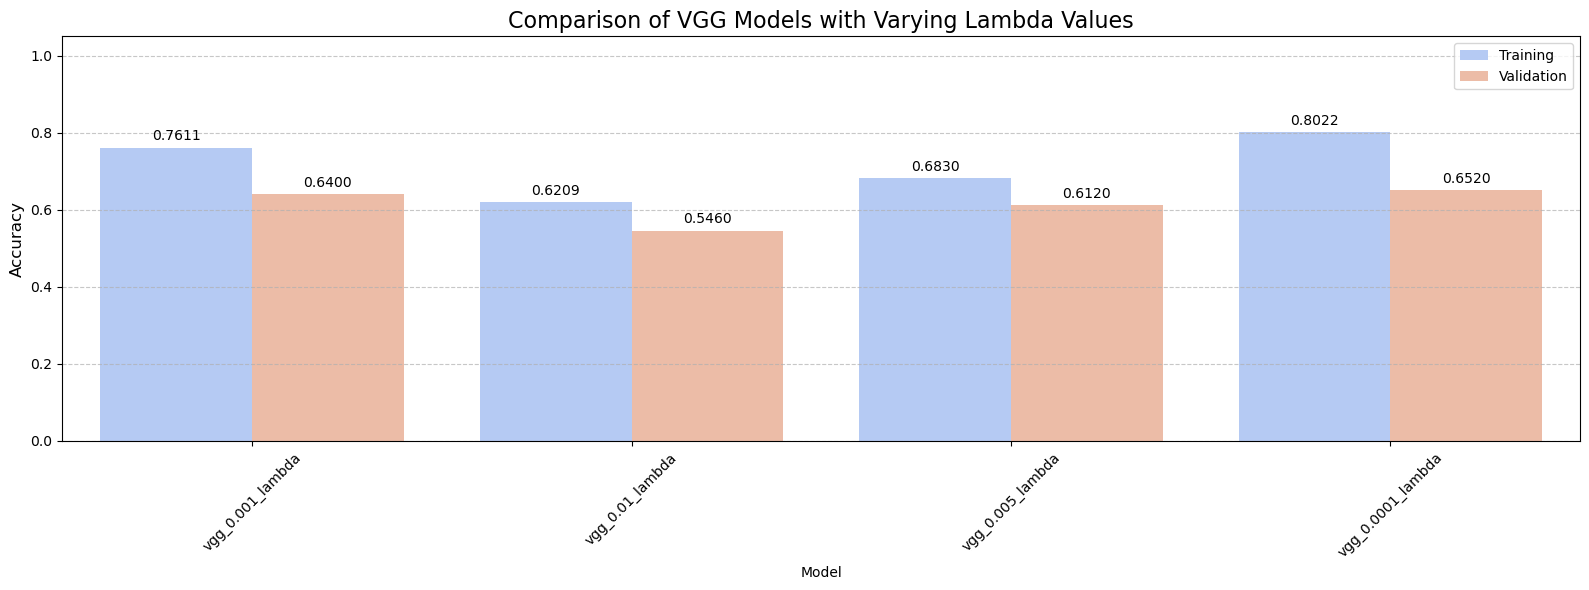

In [9]:
mt.plot_model_results(
    model_results,
    "Comparison of VGG Models with Varying Lambda Values",
    figsize=(16, 6),
)

In [ ]:
vgg_best_model = build_vgg_model(l2_strength=0.005)
vgg_best_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Callbacks
early_stopping = EarlyStopping(
    monitor="val_accuracy", patience=10, restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "models/vgg_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
)

# Train with full dataset
vgg_best_history = vgg_best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, checkpoint],
    verbose=1,
)

Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.1453 - loss: 4.4615 - val_accuracy: 0.2642 - val_loss: 3.2324
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 258s 989ms/step - accuracy: 0.2128 - loss: 3.0559 - val_accuracy: 0.3530 - val_loss: 2.4969
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 258s 989ms/step - accuracy: 0.2981 - loss: 2.4812 - val_accuracy: 0.3804 - val_loss: 2.1851
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 258s 988ms/step - accuracy: 0.3436 - loss: 2.2183 - val_accuracy: 0.4073 - val_loss: 1.9865
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 258s 987ms/step - accuracy: 0.3837 - loss: 2.0309 - val_accuracy: 0.4645 - val_loss: 1.7750
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.4292 - loss: 1.8708 - val_accuracy: 0.5173 - val_loss: 1.6661
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.4536 - loss: 1.7961 - val_accuracy: 0.5485 - val_loss: 1.5386
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.5080 - loss: 1.633

In [146]:
mt.save_model_and_history(vgg_best_model, vgg_best_history, "vgg_best")

Model saved to models/vgg_best.keras
Full history saved to models/history/vgg_best_history.pkl


In [11]:
model_path = "./models/vgg_best.keras"
history_path = "./models/history/vgg_best_history.pkl"

# load the model and it's history if it exists in folder directory
if os.path.exists(model_path) and os.path.exists(history_path):
    print("Loading saved model and training history...")
    vgg_best_model = load_model(model_path)

    with open(history_path, "rb") as f:
        vgg_best_history = pickle.load(f)
    print("Model and history loaded successfully!")

Loading saved model and training history...
Model and history loaded successfully!


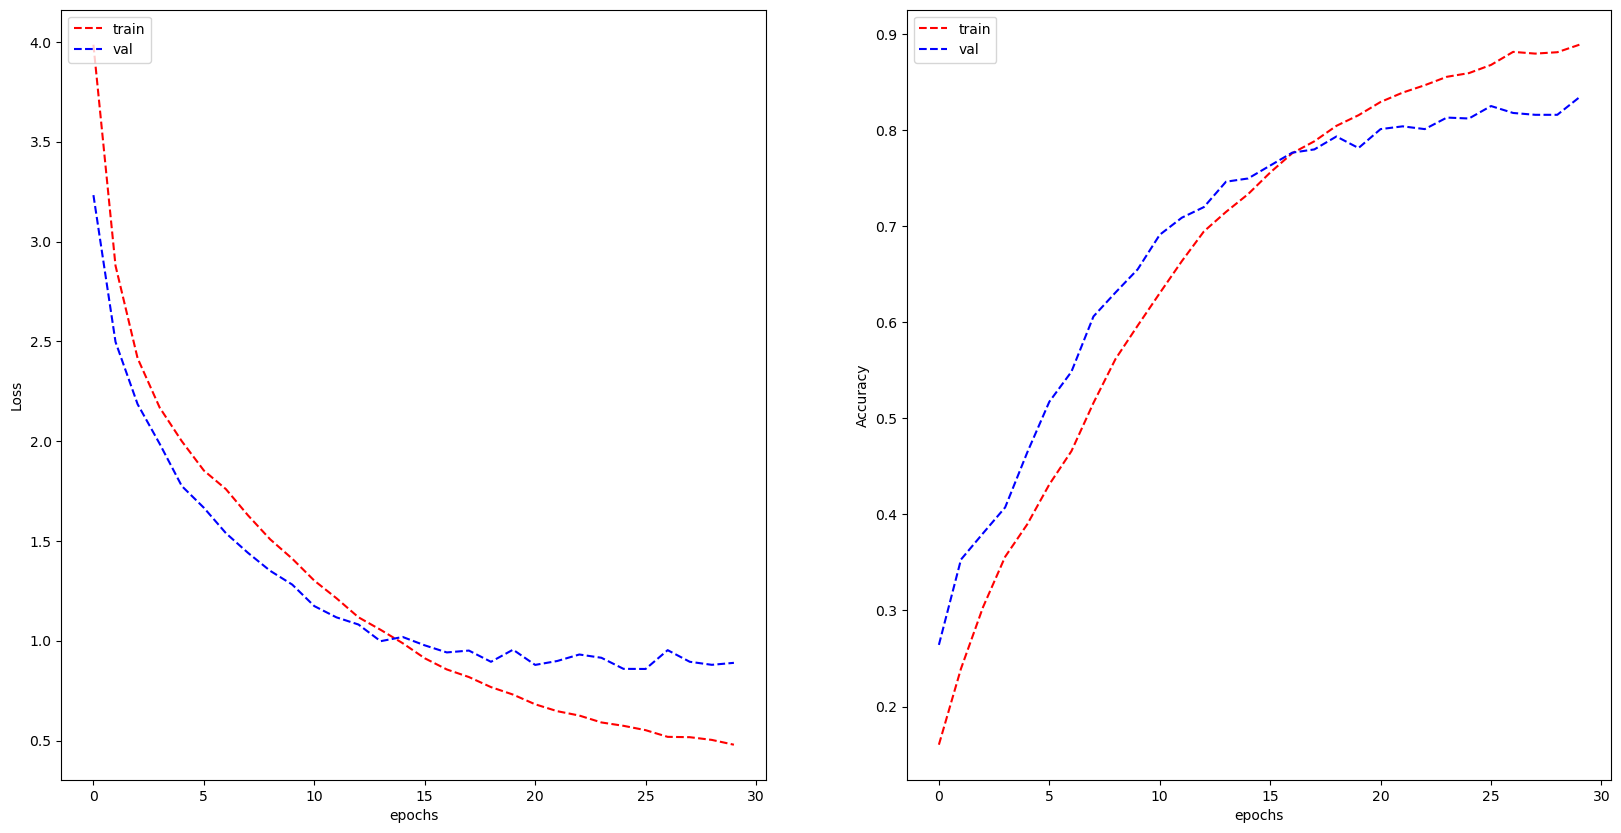

In [ ]:
mt.plot_learning_curve(
    vgg_best_history.history["loss"],
    vgg_best_history.history["val_loss"],
    vgg_best_history.history["accuracy"],
    vgg_best_history.history["val_accuracy"],
    metric_name="Accuracy",
)

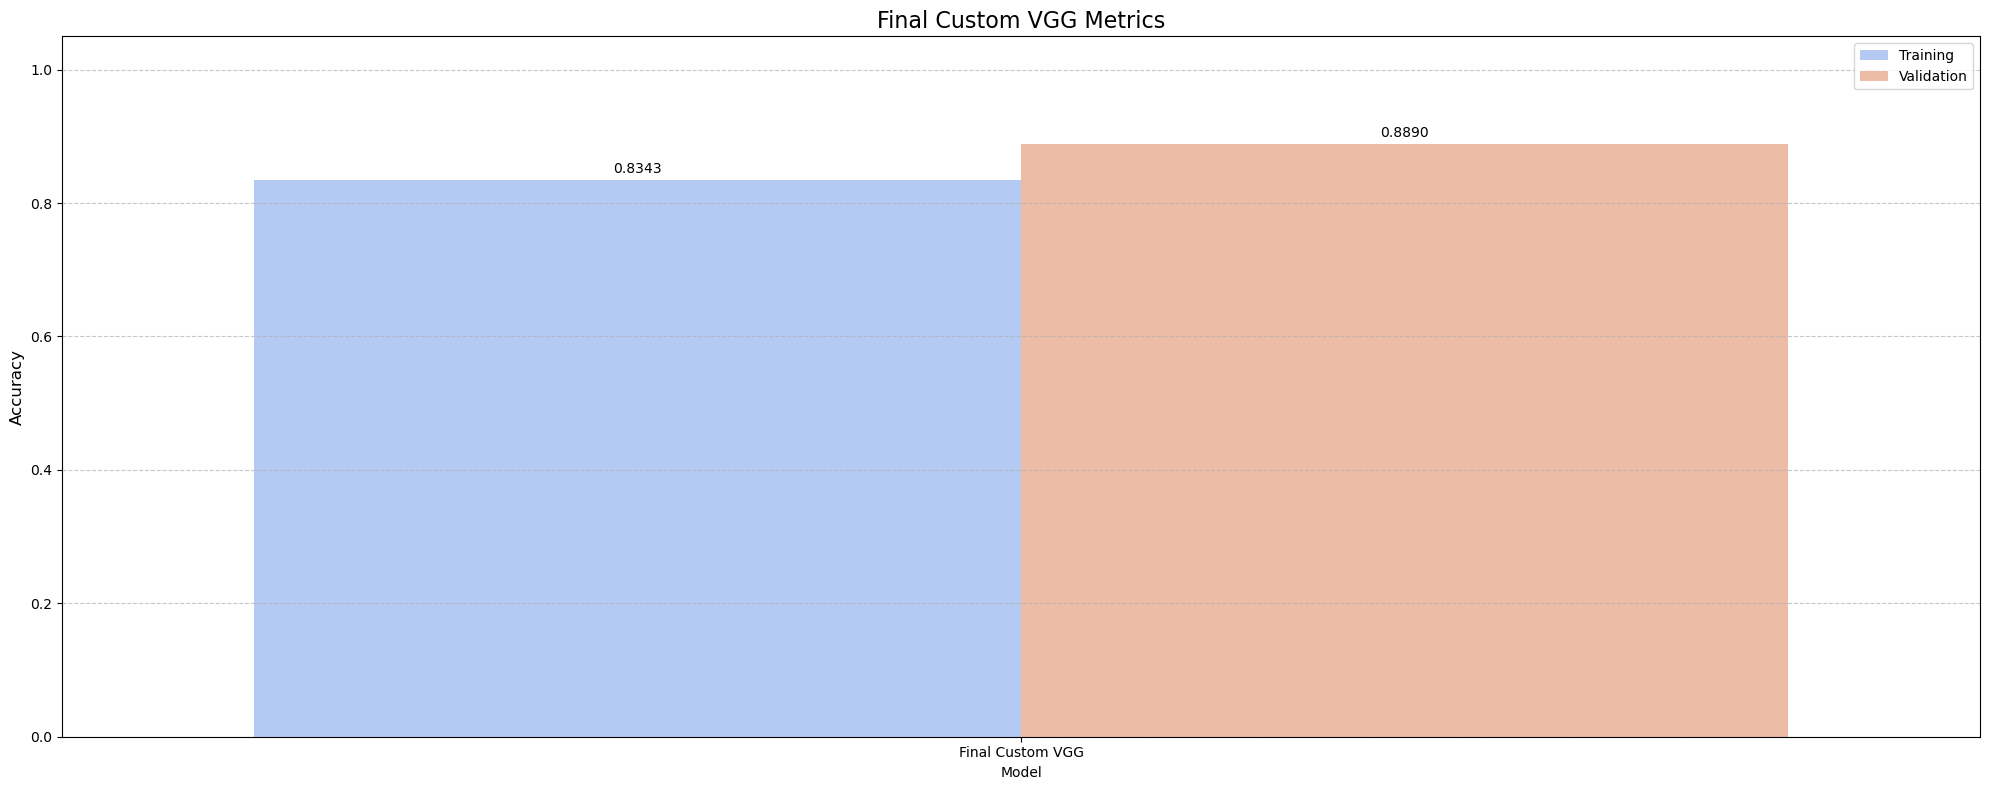

In [161]:
# Get CNN accuracies
best_vgg_epoch = np.argmax(vgg_best_history.history["val_accuracy"])
best_vgg_val_accuracy = vgg_best_history.history["val_accuracy"][best_vgg_epoch]
best_vgg_train_accuracy = vgg_best_history.history["accuracy"][best_vgg_epoch]

model_results = {
    "Final Custom VGG": (best_vgg_val_accuracy, best_vgg_train_accuracy),
}

mt.plot_model_results(
    model_results, "Final Custom VGG Metrics", figsize=(20, 8)
)

# III. MODEL PERFORMANCE VISUALIZATION

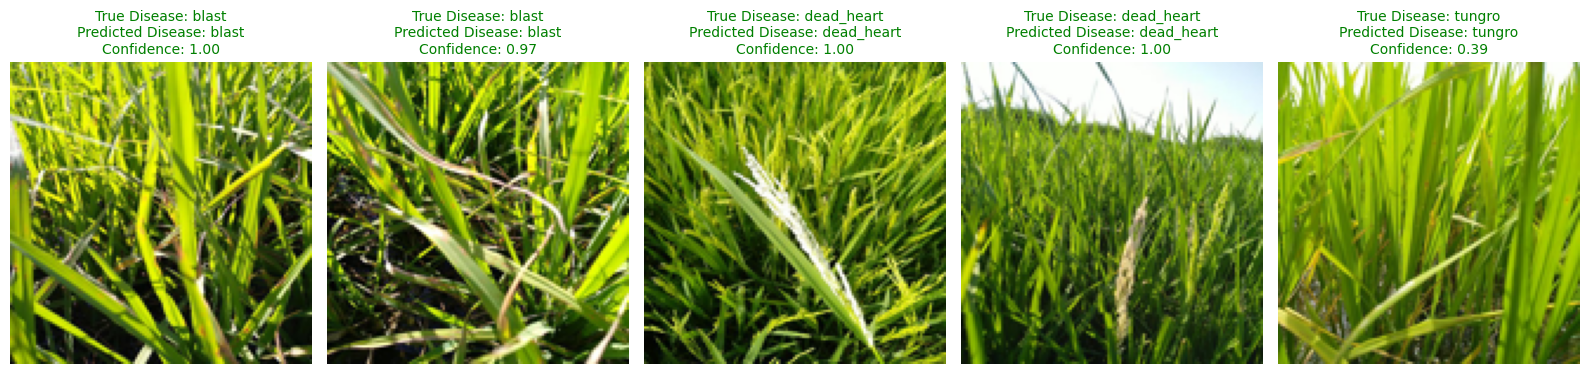

Correctly predicted 5 out of 5 images (100.0%)


In [46]:
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
class_names_list = [inv_class_indices[i] for i in range(len(inv_class_indices))]

mt.predict_and_show_samples(
    model=vgg_best_model,
    df=val_df,
    class_names=class_names_list,
    num_samples=5,
    random_select=True,
    figsize=(16, 8),
    rows=1,
    cols=5,
    label_col="label",
    prediction_type="Disease",
)